In [2]:
import initialize_notebook

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from ams.DateRange import DateRange
%matplotlib inline
from pathlib import Path

from pyspark.sql import functions as F

from ams.config import constants
from ams.services import spark_service
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
twitter_folder = 'twitter'

learning_prep_path = Path(constants.DATA_PATH, twitter_folder, "learning_prep_drop", "learning_prep_drop_2020-09-20_13-29-52-218.1", "part-00000-3d4f75b7-a9eb-4c58-8593-d57ecab7462b-c000.csv")

In [4]:
df_twitter = pd.read_csv(str(learning_prep_path))


C:\ProgramData\Miniconda3\envs\alpha_media_signal\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9,16,23,26,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
from ams.services import ticker_service

tickers = df_twitter['f22_ticker'].unique().tolist()

Setting up logging...
Will use logging path: C:\Users\Chris\workspaces\data\logs\alpha_media_signal


In [6]:
date_range = DateRange.from_date_strings(from_date_str="2020-08-01", to_date_str="2020-09-30")
df_stock_data = ticker_service.get_tickers_in_range(tickers=tickers, date_range=date_range)
print(f'{df_stock_data.shape[0]}')

83732


In [7]:
df_stock_renamed = df_stock_data.rename(columns={"ticker": "f22_ticker"})

if 'None' in df_stock_renamed.columns:
    df_stock_renamed = df_stock_renamed.drop(columns=['None'])

df_stock_clean = df_stock_renamed.drop(columns=['lastupdated'])
print(f'Twitter: {df_twitter.shape[0]}')
print(f'Quandl: {df_stock_renamed.shape[0]}')

print(f'{df_twitter.columns}')
print(f'{df_stock_renamed.columns}')

df_merged = pd.merge(df_twitter, df_stock_renamed, how='inner', left_on=["f22_ticker","date"], right_on=["f22_ticker","date"])

df_merged_clean = df_merged.sample(frac=1.0)

print(f'Num merged: {df_merged.shape[0]}')

Twitter: 3652061
Quandl: 83732
Index(['created_at', 'created_at_timestamp', 'user_screen_name', 'favorite_count', 'in_reply_to_screen_name', 'user_verified', 'metadata_result_type', 'user_listed_count', 'user_time_zone', 'user_has_extended_profile', 'in_reply_to_status_id', 'user_statuses_count', 'user_protected', 'user_is_translation_enabled', 'user_location', 'lang', 'user_geo_enabled', 'place_country', 'place_name', 'possibly_sensitive', 'user_friends_count', 'retweet_count', 'user_follow_request_sent', 'user_followers_count', 'f22_ticker', 'f22_has_cashtag', 'f22_ticker_in_text', 'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 'f22_sentiment_neg', 'f22_sentiment_compound', 'f22_compound_score', 'date'], dtype='object')
Index(['f22_ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'closeunadj', 'lastupdated'], dtype='object')
Num merged: 1218219


In [8]:
from ams.utils import date_utils

df_blue_rabbit = df_merged_clean

df_blue_rabbit.sort_values("f22_ticker", inplace=True)

def get_price_in_days(date_string: str, ticker: str):
    high_price = ticker_service.get_next_trading_day_high(ticker=ticker, date_str=date_string)
    return high_price

df_blue_rabbit['future_price'] = df_blue_rabbit.apply(lambda x: get_price_in_days(x['date'], x['f22_ticker']), axis=1)

In [9]:
df_blue_rabbit['stock_val_change'] = (df_blue_rabbit['future_price'] - df_blue_rabbit['close']) / df_blue_rabbit['future_price'] * 100.0

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_blue_rabbit['stock_val_change_scaled'] = scaler.fit_transform(df_blue_rabbit[['stock_val_change']])

df_blue_rabbit['buy_sell'] = df_blue_rabbit['stock_val_change_scaled'].apply(lambda x: 1 if x >=0 else -1)

In [11]:
df_g_counting = df_blue_rabbit.groupby(['f22_ticker', 'date'])
s_sized = df_g_counting.size()

df_renamed = s_sized.to_frame().rename(columns={0: 'f22_day_tweet_count'})

df_res = df_blue_rabbit.join(df_renamed, on=["f22_ticker", "date"], how="inner")

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [12]:
# print(f"df_green_hornet cols: {set(df_blue_rabbit.columns)}")
from typing import List
bool_cols = ['user_has_extended_profile', 'f22_ticker_in_text', 'user_geo_enabled', 'possibly_sensitive']

def convert_type(df: pd.DataFrame, cols: List[str], type_str):
    for c in cols:
        df[c] = df[c].astype(type_str)
    return df

df_c_1 = convert_type(df_res, bool_cols, 'bool')

df_converted = convert_type(df_res, ['user_followers_count', 'f22_compound_score'], 'float64')


from fastai.tabular.core import FillMissing, Categorify, Normalize

procs = [FillMissing, Categorify, Normalize]

# df_types = df_res.dtypes.to_frame()
# print(df_types.head()

# print(df_blue_rabbit.dtypes)
g = df_converted.columns.to_series().groupby(df_res.dtypes).groups

print(g)
# cat_vars = ['user_screen_name', 'in_reply_to_screen_name', 'user_verified', 'metadata_result_type', 'user_listed_count', 
#             'user_time_zone', 'user_has_extended_profile', 'in_reply_to_status_id', 'user_protected', 
#             'user_is_translation_enabled', 'user_location', 'lang', 'user_geo_enabled', 'place_country', 'place_name', 
#             'possibly_sensitive', 'retweet_count', 'user_follow_request_sent', 'f22_ticker', 'f22_has_cashtag', 
#             'f22_ticker_in_text', 'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 
#             'f22_sentiment_neg', 'f22_sentiment_compound', 'f22_compound_score'
#            ]

cat_vars = ['user_screen_name', 'in_reply_to_screen_name', 'metadata_result_type', 
            'user_has_extended_profile', 'user_location', 'lang', 'user_geo_enabled', 'place_country', 
            'place_name', 'possibly_sensitive', 'user_followers_count', 'f22_ticker', 'f22_ticker_in_text', 
            'f22_compound_score', 'date'
           ]
cont_vars = ['user_time_zone', 'in_reply_to_status_id', 'retweet_count', 'user_follow_request_sent', 
             'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 'f22_sentiment_neg', 
             'f22_sentiment_compound', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'closeunadj', 
             'created_at_timestamp'
            ]

{bool: ['user_verified', 'user_has_extended_profile', 'user_protected', 'user_is_translation_enabled', 'user_geo_enabled', 'possibly_sensitive', 'f22_has_cashtag', 'f22_ticker_in_text'], int64: ['created_at_timestamp', 'favorite_count', 'user_listed_count', 'user_statuses_count', 'user_friends_count', 'buy_sell', 'f22_day_tweet_count'], float64: ['user_time_zone', 'in_reply_to_status_id', 'retweet_count', 'user_follow_request_sent', 'user_followers_count', 'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 'f22_sentiment_neg', 'f22_sentiment_compound', 'f22_compound_score', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'closeunadj', 'future_price', 'stock_val_change', 'stock_val_change_scaled'], object: ['created_at', 'user_screen_name', 'in_reply_to_screen_name', 'metadata_result_type', 'user_location', 'lang', 'place_country', 'place_name', 'f22_ticker', 'date', 'lastupdated']}


In [113]:
import math
from fastai.tabular.core import TabularPandas, CategoryBlock, TabDataLoader, DataLoaders, ifnone
from fastai.tabular.learner import tabular_learner, F1Score, accuracy
from fastai.data.transforms import FuncSplitter
from random import shuffle

# df_limited = df_converted.iloc[:1000]

df_green_angel = df_converted.sample(frac=1.0)

a_dist = df_green_angel["date"].unique().tolist()
shuffle(a_dist)
num_dates = len(a_dist)
pct_train = 80

print(f"Num dates: {num_dates}")

train_cut_off_ndx = math.floor(num_dates * (pct_train / 100)) - 1
train_cut_off = a_dist[train_cut_off_ndx]
print(f"tcoi: {train_cut_off_ndx}; {train_cut_off}")

def split(dt_str):
    return True if train_cut_off > dt_str else False

print(f"Num converted: {df_green_angel.shape[0]}")

splits = FuncSplitter(split)(df_green_angel["date"])
print(f"tup_1: {len(splits[0])}; tup_2: {len(splits[1])}")

Num dates: 27
tcoi: 20; 2020-09-08
Num converted: 1218219
tup_1: 582628; tup_2: 635591


In [123]:
drop_columns = ['lastupdated', 'future_price', 
                'stock_val_change', 'stock_val_change_scaled', "date", "created_at_timestamp"]

df_dropped = df_green_angel.drop(labels=drop_columns, axis=1)

print(f"df_dropped: {df_dropped.columns}")

df_dropped: Index(['created_at', 'user_screen_name', 'favorite_count', 'in_reply_to_screen_name', 'user_verified', 'metadata_result_type', 'user_listed_count', 'user_time_zone', 'user_has_extended_profile', 'in_reply_to_status_id', 'user_statuses_count', 'user_protected', 'user_is_translation_enabled', 'user_location', 'lang', 'user_geo_enabled', 'place_country', 'place_name', 'possibly_sensitive', 'user_friends_count', 'retweet_count', 'user_follow_request_sent', 'user_followers_count', 'f22_ticker', 'f22_has_cashtag', 'f22_ticker_in_text', 'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 'f22_sentiment_neg', 'f22_sentiment_compound', 'f22_compound_score', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'closeunadj', 'buy_sell', 'f22_day_tweet_count'], dtype='object')


In [124]:
print(f"df_dropped: {df_dropped.shape[0]}")


df_dropped: 1218219


In [125]:
procs = [FillMissing, Categorify, Normalize]

cat_vars = ['user_screen_name', 'in_reply_to_screen_name', 'metadata_result_type', 
            'user_has_extended_profile', 'user_location', 'lang', 'user_geo_enabled', 'place_country', 
            'place_name', 'possibly_sensitive', 'user_followers_count', 'f22_ticker', 'f22_ticker_in_text', 
            'f22_compound_score']

In [122]:
from fastai.optimizer import Adam
from functools import partial
from fastai.learner import Learner
from fastai.layers import MSELossFlat
from fastai.metrics import RocAuc

cat_vars = [] # ["f22_ticker"]
cont_vars = ['f22_sentiment_compound']

# cont_vars = ['user_time_zone', 'in_reply_to_status_id', 'retweet_count', 'user_follow_request_sent', 
#              'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 'f22_sentiment_neg', 
#              'f22_sentiment_compound', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'closeunadj', 
#             ]

df_tmp = df_dropped #[["f22_ticker", "f22_compound_score", 'user_screen_name', "buy_sell"]]

df_cherry = df_tmp

to = TabularPandas(df_cherry, procs, cat_vars, cont_vars, y_names="buy_sell",
                       splits=splits, do_setup=True)
trn_dl = TabDataLoader(to.train, bs=64, num_workers=0, shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=128, num_workers=0)

dls = DataLoaders(trn_dl, val_dl).cuda()

opt_func = partial(Adam, wd=0.01, eps=1e-5)

# MSELossFlat()
learner = tabular_learner(dls, layers=[29, 50, 29], metrics=[MSELossFlat()], opt_func=opt_func)

learner.fit_one_cycle(20)

(#5) [0,nan,nan,nan,'01:52']
(#5) [1,nan,nan,nan,'02:08']
(#5) [2,nan,nan,nan,'01:43']
(#5) [3,nan,nan,nan,'01:47']
(#5) [4,nan,nan,nan,'01:43']
(#5) [5,nan,nan,nan,'01:44']
(#5) [6,nan,nan,nan,'01:44']
(#5) [7,nan,nan,nan,'01:41']
(#5) [8,nan,nan,nan,'01:43']
(#5) [9,nan,nan,nan,'01:23']


KeyboardInterrupt: 

In [69]:
to = TabularPandas(df_cherry, procs, cat_vars, cont_vars, y_names="buy_sell",
                       splits=splits, do_setup=True)
trn_dl = TabDataLoader(to.train, bs=64, num_workers=0, shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=128, num_workers=0)

dls = DataLoaders(trn_dl, val_dl).cuda()

learner = tabular_learner(dls, metrics=accuracy)

In [70]:
from fastai.callback.schedule import LRFinder

learner.fit_one_cycle(5, cbs=LRFinder(num_it=100))

(#3) [0,nan,'00:34']


In [71]:
def emb_sz_rule(n_cat): 
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

def get_emb_sz(to, sz_dict=None):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_one_emb_sz(to.procs.classes, n, sz_dict) for n in to.cat_names]

emb_szs = get_emb_sz(to); print(emb_szs)

[(46857, 600), (9702, 273), (3, 3), (3, 3), (17433, 380), (2, 2), (3, 3), (39, 12), (408, 46), (3, 3), (4454, 177), (1742, 104), (3, 3), (14916, 348), (2, 2), (3, 3), (2, 2)]


In [91]:
from fastai.torch_core import Module
from fastcore.utils import is_listy
from torch import nn
from fastai.layers import Embedding, LinBnDrop
import torch

class TabularModel(Module):    
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0., y_range=None, use_bn=True, bn_final=False):
        ps = ifnone(ps, [0]*len(layers))
        if not is_listy(ps): ps = [ps]*len(layers)
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz]
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and i!=0, p=p, act=a)
                       for i,(p,a) in enumerate(zip([0.]+ps,actns))]
        if bn_final: _layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*_layers)
    
    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

In [92]:
model = TabularModel(emb_szs, len(to.cont_names), 1, [1000,500])

In [93]:
# dbch = to.databunch()
# dbch.valid_dl.show_batch()

In [94]:
from fastai.optimizer import Adam
from functools import partial
from fastai.learner import Learner
from fastai.layers import MSELossFlat

opt_func = partial(Adam, wd=0.01, eps=1e-5)
learner = Learner(dls, model, MSELossFlat(), opt_func=opt_func)

In [95]:
learner.fit_one_cycle(5)

(#4) [0,nan,nan,'01:31']
(#4) [1,nan,nan,'01:35']
(#4) [2,nan,nan,'01:35']
(#4) [3,nan,nan,'01:35']
(#4) [4,nan,nan,'01:34']


In [ ]:
from fastai.tabular.learner import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learner)

interp.plot_top_losses(4, figsize=(20,25))

In [ ]:
procs = [FillMissing, Normalize]

to = TabularPandas(df_dropped, y_names="buy_sell", y_block=CategoryBlock(),
                       splits=splits)
trn_dl = TabDataLoader(to.train)
val_dl = TabDataLoader(to.valid)

dls = DataLoaders(trn_dl, val_dl)#.cuda()

learner = tabular_learner(dls, metrics=accuracy)

In [ ]:
from fastai.tabular.learner import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_top_losses(4, figsize=(20,25))

(#3) [0,nan,'03:11']


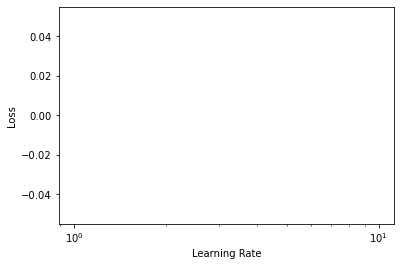

In [107]:
# from fastai.callback.schedule import lr_find
# lr = lr_find(learn)

In [98]:
learn.fit_one_cycle(10, cbs=LRFinder(num_it=100))

# from fastai.callback.schedule import LRFinder
# learn.fit(20, cbs=LRFinder(num_it=100))


(#3) [0,nan,'40:09']


In [112]:
procs = [FillMissing, Normalize]

to = TabularPandas(df_dropped, y_names="buy_sell", y_block=CategoryBlock(),
                       splits=splits)
trn_dl = TabDataLoader(to.train)
val_dl = TabDataLoader(to.valid)

dls = DataLoaders(trn_dl, val_dl)#.cuda()

learner = tabular_learner(dls, metrics=accuracy)

ZeroDivisionError: float division by zero

In [109]:
from fastai.tabular.learner import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_top_losses(4, figsize=(20,25))



RuntimeError: DataLoader worker (pid(s) 10800, 17816, 9156, 19476, 11816, 6928, 22256, 9988, 21780, 15416, 1984, 14480, 12308, 20608, 18280, 19692, 9380, 2096, 17932, 20900, 2528, 10204, 22264, 21644, 22116, 22260, 14080, 4612) exited unexpectedly

In [203]:
from datetime import timedelta
import random

def split_by_ticker():
    min_count = 1
    max_count = 100000
    
    # NOTE: The sort will be preserved
    df_res.sort_values(by=['date'], inplace=True, ascending=False)
    df_holdout_raw = df_res[['f22_ticker', 'date']].groupby(['f22_ticker', 'date']).filter(lambda group: len(group) >= min_count and len(group) <= max_count)

    df_g_holdout = df_holdout_raw.groupby(['f22_ticker', 'date'])

    num_groups = 50

    holdout_indexes = []
    group_count = 0
    youngest_date = '2099-01-01'
    for group_name, df_group in df_g_holdout:
        group_count += 1
        if group_count > num_groups:
            break
        for row_index, row in df_group.iterrows():
            holdout_indexes.append(row_index)

    df_holdouts = df_res[df_res.index.isin(holdout_indexes)]

    embargo_tickers = df_holdouts['f22_ticker'].unique().tolist()

    df_samp = df_res[~df_res["f22_ticker"].isin(embargo_tickers)]

    print(f"ho: {df_holdouts.shape[0]}; samp: {df_samp.shape[0]}")

    return df_samp, df_holdouts

def ho_split_by_date(df, num_holdouts = 40000):
    df.sort_values(by=['date'], inplace=True)
    
    if num_holdouts > 0:
        df_holdouts = df.iloc[-num_holdouts:]
        df_samp = df.iloc[:-num_holdouts]

        f22_dates = df_holdouts["date"].unique().tolist()
        df_samp = df_samp[~df_samp["date"].isin(f22_dates)]
    else:
        df_samp = df
        df_holdouts = None
    
    return df_samp, df_holdouts

def ho_split_by_days(df, num_days_to_pull=1):
    date_max = df["date"].max()
    date_min = df["date"].min()
    
    dt_max = date_utils.parse_std_datestring(date_max)
    dt_min = date_utils.parse_std_datestring(date_min)

    total_days = (dt_max - dt_min).days

    days_to_pull = []
    for i in range(num_days_to_pull + 1):
        rnd_days = random.randint(i, 10)

        rand_dt = dt_min + timedelta(days=rnd_days)
        rand_date_string = date_utils.get_standard_ymd_format(rand_dt)
        days_to_pull.append(rand_date_string)
    
    df_samp = df[~df["date"].isin(days_to_pull)]
    df_holdouts = df[df["date"].isin(days_to_pull)]
                                  
    return df_samp, df_holdouts

In [204]:
df_samp, df_holdouts = ho_split_by_days(df_res, num_days_to_pull=3) #split_by_ticker(df_res)

print(f"df_samp: {df_samp.shape[0]}; df_holdouts: {df_holdouts.shape[0]}")

SyntaxError: EOL while scanning string literal (<ipython-input-204-ebd9a014b7f8>, line 3)

In [191]:
import math
from sklearn.model_selection import train_test_split
import numpy as np
import random

def split_by_ticker():
    col_ticker = "f22_ticker"
    tickers = df_samp[col_ticker].unique().tolist()
    random.shuffle(tickers)

    num_ticks = len(tickers)
    print(num_ticks)
    
    train_tickers = tickers[:math.floor(num_ticks * .8)]
    test_tickers = tickers[math.ceil(-(num_ticks * .2)):]

    train_set = df_samp[df_samp[col_ticker].isin(train_tickers)]
    print(f"train_set: {train_set.shape[0]}")

    test_set = df_samp[df_samp[col_ticker].isin(test_tickers)]
    print(f"test_set: {test_set.shape[0]}")

    train_set = train_set.drop(columns=[col_ticker], axis=1)
    test_set = test_set.drop(columns=[col_ticker], axis=1)

def split_by_date(df):
    df.sort_values(by=['date'], inplace=True)
    
    num_rows = df.shape[0]
    
    print(f"num_rows: {num_rows}")
    
    df_train = df.iloc[:math.ceil(num_rows * .8)]
    df_test = df.iloc[math.ceil(-(num_rows * .2)):]
    
    f22_dates = df_test["date"].unique().tolist()
    df_train = df_train[~df_train["date"].isin(f22_dates)]
    
    print(f"df_train: {df_train.shape[0]}")
    print(f"df_test: {df_test.shape[0]}")
    
    return df_train, df_test

def split_by_days(df, num_days_to_pull=1):
    date_max = df["date"].max()
    date_min = df["date"].min()
    
    dt_max = date_utils.parse_std_datestring(date_max)
    dt_min = date_utils.parse_std_datestring(date_min)

    total_days = (dt_max - dt_min).days

    days_to_pull = []
    for i in range(num_days_to_pull + 1):
        rnd_days = random.randint(0,i)

        rand_dt = dt_min + timedelta(days=rnd_days)
        rand_date_string = date_utils.get_standard_ymd_format(rand_dt)
        days_to_pull.append(rand_date_string)
    
    df_train = df[~df["date"].isin(days_to_pull)]
    df_test = df[df["date"].isin(days_to_pull)]
                                  
    return df_train, df_test

In [192]:
df_shuff = df_samp.sample(frac=1.0)

train_set, test_set = split_by_days(df_shuff, num_days_to_pull=7) # split_by_ticker()
 
print(f"train_set: {train_set.shape[0]}; test_set: {test_set.shape[0]}")

train_set: 352691
test_set: 129295


In [193]:
def balance_df(df: DataFrame):
    df_samp_buy = df[df["buy_sell"] == 1]
    df_samp_sell = df[df["buy_sell"] == -1]

    num_buy = df_samp_buy.shape[0]
    num_sell = df_samp_sell.shape[0]
    if num_buy <= num_sell:
        frac = df_samp_buy.shape[0] / df_samp_sell.shape[0]
        df_samp_sell = df_samp_sell.sample(frac=frac)
    else:
        frac = df_samp_sell.shape[0] / df_samp_buy.shape[0]
        df_samp_buy = df_samp_buy.sample(frac=frac)
    
    print(f"df_samp_buy: {df_samp_buy.shape[0]}")
    print(f"df_samp_sell: {df_samp_sell.shape[0]}")

    return pd.concat([df_samp_buy, df_samp_sell]).sample(frac=1.0)

col_ticker = "f22_ticker"

train_set_bal = balance_df(train_set)
test_set_bal = balance_df(test_set)

train_cols = narrow_cols.copy()
train_cols.append('f22_day_tweet_count')
train_cols.remove('buy_sell')
train_cols.remove('date')

train_cols.remove(col_ticker)

X_train = np.array(train_set_bal[train_cols])
X_test = np.array(test_set_bal[train_cols])

y_train = np.array(train_set_bal['buy_sell'])
y_test = np.array(test_set_bal['buy_sell'])

print(f"{train_set_bal.shape[0]}")

print(f"Number of features: {len(train_cols)}")

ZeroDivisionError: division by zero

0.6443547429656892: Elapsed time: 217.2079997062683 seconds.


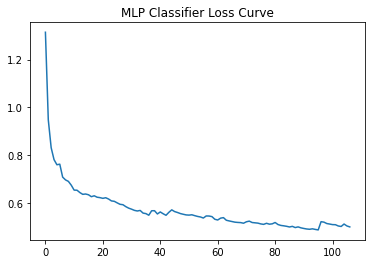

In [201]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import accuracy_score
# import time
# 
# start = time.time()
# clf = MLPClassifier(hidden_layer_sizes=(29, 50, 29), max_iter=800, tol=1e-16, activation='relu', solver='adam')
# clf.fit(X_train, y_train)  # Fit data
# prediction = clf.predict(X_test)  # Predict results for x_test
# accs = accuracy_score(y_test, prediction)  # Accuracy Score
# end = time.time()
# 
# print(f"{accs}: Elapsed time: {end-start} seconds.")
# 
# import matplotlib.pyplot as plt
# 
# fig, ax = plt.subplots()
# ax.set_title("MLP Classifier Loss Curve")
# ax.plot(clf.loss_curve_)
# 
# fig.canvas.draw()
# 

In [202]:
# from statistics import mean
# 
# df_holdouts_tweet_bal = df_holdouts[df_holdouts["f22_day_tweet_count"] > 0]
# df_holdouts_bal = balance_df(df_holdouts_tweet_bal)
# 
# df_g_holdout = df_holdouts_bal.groupby(['f22_ticker', 'date'])
# 
# group_count = 0
# acc_acc = []
# for group_name, df_group in df_g_holdout:
#     X_holdout = np.array(df_group[train_cols])
#     y_holdout = np.array(df_group['buy_sell'])
# 
#     prediction = clf.predict(X_holdout)
#     accs = accuracy_score(y_holdout, prediction)
#     acc_acc.append(accs)
#         
# print(f"Mean: {mean(acc_acc)}")
# 
# # holdout_set.head(100)
# 
# g_tickers = []
# for group_name, df_group in df_g_holdout:
#     g_tickers.append(group_name[0])
# 
# g_tickers = set(g_tickers)
#     
# # print(f"g_tickers: {g_tickers}")
# 

KeyboardInterrupt: 